<a href="https://colab.research.google.com/github/sidharthbudania/stock_predictor/blob/main/stock_predictor_collab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yahoo_fin

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 702.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=c4d32e90538408543eb19dcc1a036f6d21e66d20f061c04e8dfecaf42cff1364
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt

In [ ]:

N_STEPS = 7
LOOKUP_STEPS = [1, 2, 3]
STOCK = 'GOOGL'
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [ ]:
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')
init_df

,open,high,low,close,adjclose,volume,ticker
2021-08-09,135.942505,137.184006,135.339493,136.912994,136.756042,17760000,GOOGL
2021-08-10,137.341995,137.772507,136.364502,136.807007,136.650177,19414000,GOOGL
2021-08-11,137.181503,137.682495,136.271500,136.279007,136.122787,15352000,GOOGL
2021-08-12,135.975494,137.300003,135.425507,137.194000,137.036728,16506000,GOOGL
2021-08-13,137.250000,137.856506,137.033005,137.727493,137.569611,15948000,GOOGL
...,...,...,...,...,...,...,...
2024-08-09,160.009995,163.789993,159.059998,163.669998,163.669998,28602300,GOOGL
2024-08-12,164.350006,164.899994,161.839996,162.289993,162.289993,15895300,GOOGL
2024-08-13,163.410004,164.729996,162.970001,164.160004,164.160004,18551700,GOOGL
2024-08-14,162.399994,163.220001,157.710007,160.369995,160.369995,40591100,GOOGL


In [ ]:

init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
init_df['date'] = init_df.index

In [ ]:
init_df

,close,date
2021-08-09,136.912994,2021-08-09
2021-08-10,136.807007,2021-08-10
2021-08-11,136.279007,2021-08-11
2021-08-12,137.194000,2021-08-12
2021-08-13,137.727493,2021-08-13
...,...,...
2024-08-09,163.669998,2024-08-09
2024-08-12,162.289993,2024-08-12
2024-08-13,164.160004,2024-08-13
2024-08-14,160.369995,2024-08-14


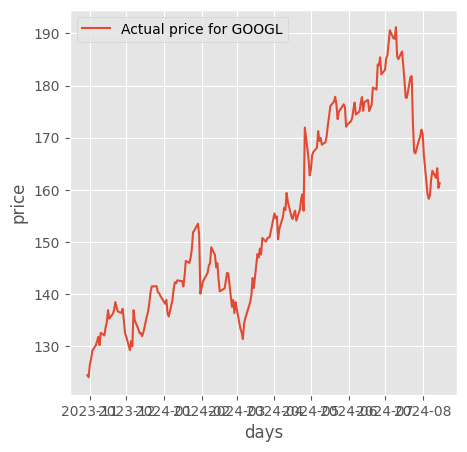

In [ ]:
plt.style.use(style='ggplot')
plt.figure(figsize=(5,5))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [ ]:
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [ ]:
init_df

,close,date,scaled_close
2021-08-09,136.912994,2021-08-09,0.496362
2021-08-10,136.807007,2021-08-10,0.495378
2021-08-11,136.279007,2021-08-11,0.490478
2021-08-12,137.194000,2021-08-12,0.498970
2021-08-13,137.727493,2021-08-13,0.503921
...,...,...,...
2024-08-09,163.669998,2024-08-09,0.744687
2024-08-12,162.289993,2024-08-12,0.731879
2024-08-13,164.160004,2024-08-13,0.749234
2024-08-14,160.369995,2024-08-14,0.714060


In [ ]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [ ]:
PrepareData(3)

(                 close       date  scaled_close    future
 2021-08-09  136.912994 2021-08-09      0.496362  0.498970
 2021-08-10  136.807007 2021-08-10      0.495378  0.503921
 2021-08-11  136.279007 2021-08-11      0.490478  0.509322
 2021-08-12  137.194000 2021-08-12      0.498970  0.494028
 2021-08-13  137.727493 2021-08-13      0.503921  0.482775
 ...                ...        ...           ...       ...
 2024-08-06  158.289993 2024-08-06      0.694756  0.744687
 2024-08-07  158.940002 2024-08-07      0.700789  0.731879
 2024-08-08  162.029999 2024-08-08      0.729466  0.749234
 2024-08-09  163.669998 2024-08-09      0.744687  0.714060
 2024-08-12  162.289993 2024-08-12      0.731879  0.722691
 
 [757 rows x 4 columns],
 array([[0.77243626],
        [0.7036659 ],
        [0.6947564 ],
        [0.7007889 ],
        [0.7294664 ],
        [0.7446868 ],
        [0.73187935],
        [0.74923444],
        [0.7140603 ],
        [0.7226915 ]], dtype=float32),
 array([[[0.4963619291557384

In [ ]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0458
Epoch 2/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037
Epoch 3/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029
Epoch 4/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026
Epoch 5/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
Epoch 6/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 7/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 8/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027
Epoch 9/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0023
Epoch 10/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031
Epoch 11/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 12/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021
Epoch 13/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021
Epoch 14/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 15/80
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0021
Epoch 16/80

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0462
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0039
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0038
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0025
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024
Epoch 16/80
94/94 ━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0330
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0039
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0044
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0043
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0044
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0031
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0026
Epoch 13/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0035
Epoch 14/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027
Epoch 15/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026
Epoch 16/80
94/94 ━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 60)               │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 120)                 │          86,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (159.46$, 160.72$, 162.76$)


In [ ]:
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

copy_df

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,close,date,scaled_close,predicted_close
2021-08-09,136.912994,2021-08-09,0.496362,137.429504
2021-08-10,136.807007,2021-08-10,0.495378,140.041504
2021-08-11,136.279007,2021-08-11,0.490478,141.261505
2021-08-12,137.194000,2021-08-12,0.498970,142.078995
2021-08-13,137.727493,2021-08-13,0.503921,141.440506
...,...,...,...,...
2024-08-09,163.669998,2024-08-09,0.744687,163.612579
2024-08-12,162.289993,2024-08-12,0.731879,163.459106
2024-08-13,164.160004,2024-08-13,0.749234,164.160004
2024-08-14,160.369995,2024-08-14,0.714060,160.369995


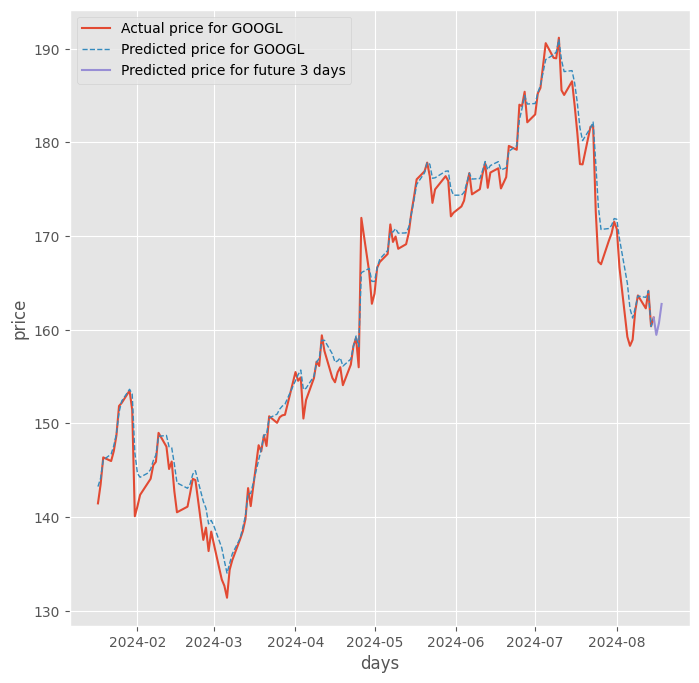

In [ ]:
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

plt.style.use(style='ggplot')
plt.figure(figsize=(8,8))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()